Simple Linear Regression is a useful approach for predicting a response on the basis of a single predictor variable. However, in practice we often have more than one prediction. For example. in the advertising data, we have examined the relationship between sales and TV advertising. We also have data for the amount of momney spent advertising on the radio and in newspapers, and we may want to know whether either of these two media is associated with sales. How can we extend our analysis of the advertising data in order to accommodate these two additional predictors? One option is to run three separate simple linear regression, each of which uses a different advertising medium as a predictor. The approach of fitting a separate simple linear regression model for each predictor is not entirely satisfactory. 
- First of all, it is unclear how to make a single prediction of sales given the three advertising media budgets, since each of the budgets is associated with a separate regression equation. 
- Second, each of the three regression equations ignores the other two media in forming estimates for the regression coefficients. 

## Background

- Suppose that we are statistical consultants hired by a client to investigate the association between advertising and sales of a particular product.
- We are provided the dataset consists of the **sales** of one particular product in 200 diferent markets, along with advertising budgets for the product in each of those markets for three diferent media: **TV**, **Radio**, and **newspaper**.
- Client has **full control** of advertising expenses in each of the three media.
- If we determine that there is an association between advertising and alses, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales.
- **OBJECTIVE**: Our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Load Dataset

- '**TV**': TV Advertising Spends, and unit is in thousands of dollars.
- '**Radio**': Radio Advertising Spends, and unit is in thousand of dollars.
- '**Newspaper**':Newspaper Advertising Spends, and unit is in thousand of dollars.
- '**Sales**':The quantities of product sale at corresponding budget of three advertising approaches, and unit is in thousand of dollars(Notice is not dollars).

In [2]:
df = pd.read_csv('../data/Advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## Data Visualization

1. TV
- Range & center: spends go from about 0.7 to 296.4, with a mean of ~147 and median of ~150.
- Spread: very high variability (SD ≈ 86), IQR ≈ (74, 219).
- Shape: fairly broad and roughly uniform—companies span the full budget range, though there are slightly fewer at the very low end.

2. Radio
- Range & center: from 0 up to 49.6, mean ~23, median ~22.9.
- Spread: moderate variability (SD ≈ 14.8), IQR ≈ (10, 36.5).
- Shape: somewhat flat but with a mild peak around the mid-20s; fewer companies spent very little or near the maximum.

3. Newspaper
- Range & center: from 0.3 to 114, mean ~30.6, median ~25.8.
- Spread: high relative variability (SD ≈ 21.8), IQR ≈ (12.8, 45.1).
- Shape: right-skewed — many firms spend very little on newspapers, but a tail of high spenders (outliers up near 100+).

4. Sales
- Range & center: sales between 1.6 and 27, mean ~14.0, median ~12.9.
- Spread: moderate variability (SD ≈ 5.2), IQR ≈ (10.4, 17.4).
- Shape: roughly bell-shaped but with a slight right skew (a few stores with unusually high sales).

Implications & next steps:
- The skew in Newspaper suggests either a log transform or binning before modeling.
- TV and Radio budgets are more evenly spread—these may show a more linear relationship with Sales.
- Sales itself is fairly symmetric, so standard linear methods should be OK, but watch for those high-sales outliers.

           count      mean        std  min     25%     50%      75%    max
TV         200.0  147.0425  85.854236  0.7  74.375  149.75  218.825  296.4
Radio      200.0   23.2640  14.846809  0.0   9.975   22.90   36.525   49.6
Newspaper  200.0   30.5540  21.778621  0.3  12.750   25.75   45.100  114.0
Sales      200.0   14.0225   5.217457  1.6  10.375   12.90   17.400   27.0


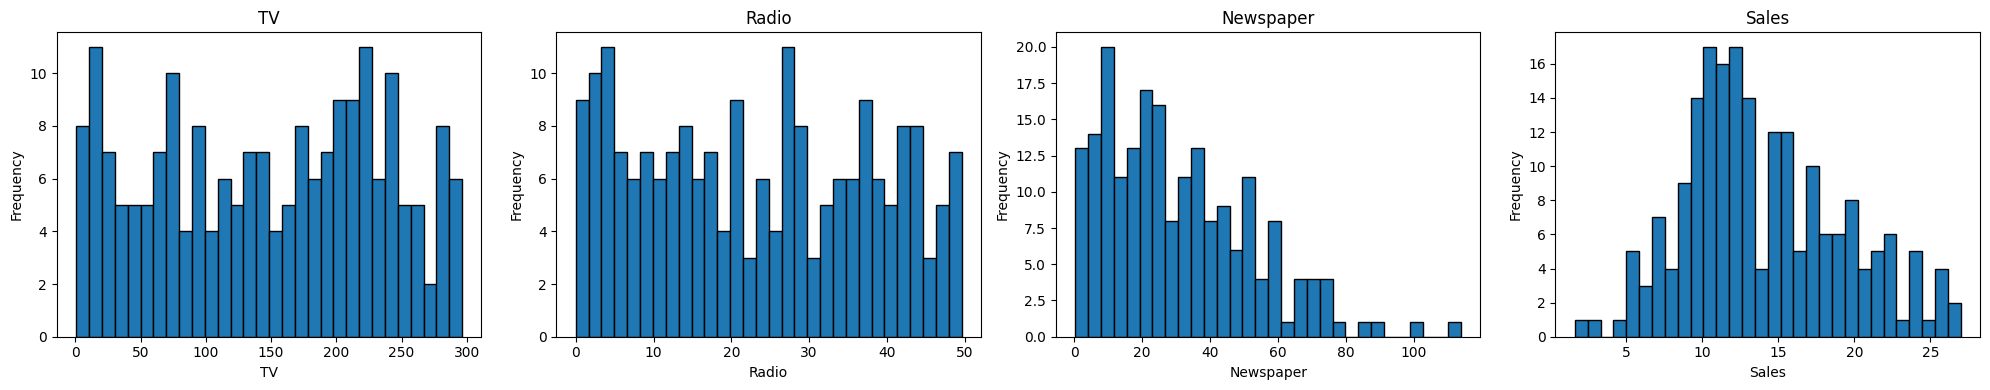

In [3]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Create a 1×4 subplot grid
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(20, 4), sharey=False)

# Plot each feature in its own subplot
for ax, col in zip(axes, numeric_cols):
    ax.hist(df[col].dropna(), bins=30, edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

print(df.describe().transpose())
plt.tight_layout()
plt.show()

## Training the Model — Estimating the Regression Coefficients

For the Multiple Linear Regression (MLR) model, we use the least squares method to estimate the regression coefficients — the same foundational approach as in simple linear regression. However, unlike simple regression, the estimation in MLR is carried out using matrix algebra.

The [complete derivation](../theory-docs/04-OLS-MLR.ipynb) can be found in the following notebook: `theory-docs/04-OLS-MLR.ipynb`

The final matrix formula for estimating the regression coefficients is:

$$
\boxed{
\hat\beta = (X^\top X)^{-1} X^\top y
}
$$

where:

- X is the matrix of input features (with a column of ones for the intercept),

- y is the response vector,

- $\hat\beta$ is the vector of estimated coefficients.

### Manual Calculation

In [8]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Add intercept term
n_samples = X.shape[0]
X_b = np.concatenate([np.ones((n_samples, 1)), X], axis=1)

# Step 3: Normal Equation
XtX = np.dot(X_b.T, X_b)
XtX_inv = np.linalg.inv(XtX)
Xty = np.dot(X_b.T, y)
beta_hat = np.dot(XtX_inv, Xty)

# Step 4: Format as DataFrame
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_hat, index=coef_names, columns=['Coefficient'])
print("Manual Computation — Coefficients:")
display(coef_df.round(4))

Manual Computation — Coefficients:


,Coefficient
Intercept,2.9389
TV,0.0458
Radio,0.1885
Newspaper,-0.0010


### Calculate with Scikit-Learn

In [9]:
# Step 1: Extract features and target
features = ['TV', 'Radio', 'Newspaper']
X = df[features].values
y = df['Sales'].values.reshape(-1, 1)

# Step 2: Fit model
model = LinearRegression()
model.fit(X, y)

# Step 3: Store and format results as DataFrame
beta_sklearn = np.concatenate([[model.intercept_[0]], model.coef_.flatten()])
coef_names = ['Intercept'] + features
coef_df = pd.DataFrame(beta_sklearn, index=coef_names, columns=['Coefficient'])

print("Scikit-Learn Estimation — Coefficients:")
display(coef_df.round(4))

Scikit-Learn Estimation — Coefficients:


,Coefficient
Intercept,2.9389
TV,0.0458
Radio,0.1885
Newspaper,-0.0010


## Several SLR v.s. MLR

In [11]:
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import pandas as pd
import numpy as np

# List of features to model separately
features = ['TV', 'Radio', 'Newspaper']
results = []

for feature in features:
    X = df[[feature]].values
    y = df['Sales'].values.reshape(-1, 1)
    n = len(y)

    model = LinearRegression()
    model.fit(X, y)

    intercept = model.intercept_[0]
    slope = model.coef_[0][0]
    y_pred = model.predict(X)

    # Residuals and RSS
    residuals = y - y_pred
    RSS = np.sum(residuals ** 2)

    # Standard error of slope
    x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
    RSE = np.sqrt(RSS / (n - 2))  # residual standard error
    SE_slope = RSE / np.sqrt(x_diff_sq_sum)

    # t-statistic and p-value
    t_stat = slope / SE_slope
    p_val = 2 * (1 - t.cdf(np.abs(t_stat), df=n - 2))

    results.append({
        'Feature': feature,
        'Intercept': intercept,
        'Slope': slope,
        'SE(Slope)': SE_slope,
        't-stat': t_stat,
        'p-value': p_val
    })

# Format and display
simple_lm_df = pd.DataFrame(results)
print("Simple Linear Regression Summary:")
display(simple_lm_df.round(4))

Simple Linear Regression Summary:


,Feature,Intercept,Slope,SE(Slope),t-stat,p-value
0,TV,7.0326,0.0475,0.0027,17.6676,0.0000
1,Radio,9.3116,0.2025,0.0204,9.9208,0.0000
2,Newspaper,12.3514,0.0547,0.0166,3.2996,0.0011


# Find separate regression equation

# The Proof of Coefficients for Multiple Linear Regression Model

In [ ]:
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

# Fit multiple linear regression model
model = LinearRegression()
model.fit(X, y)

# Get coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the result
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Optional: create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

coef_df_with_intercept = pd.concat([
    pd.DataFrame({'Feature': ['Intercept'], 'Coefficient': [intercept]}),
    coef_df
], ignore_index=True)

coef_df_with_intercept

Intercept: 2.9388893694594085
Coefficients: [ 0.04576465  0.18853002 -0.00103749]


,Feature,Coefficient
0,Intercept,2.938889
1,TV,0.045765
2,Radio,0.188530
3,Newspaper,-0.001037


In [9]:
# Add a constant (intercept term) to the model
X_with_const = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Display full summary (includes std err, t, P>|t|, R², etc.)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           1.58e-96
Time:                        08:33:40   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

# Separate SLR V.S. MLR

- The correlation between **radio** and **newspaper** is 0.35. This indivtes that markets with high newspaper advertising tend to also have high radio advertising.
- SLR inciates newspaper is associated with sales.
- MLR indicates newspaper is not associated with sales, but radio advertising is associated with sales. If we spend on more radio, the sales will tend to be higher. As the correlation maxtrix shows, we also tend to spend more on newspaper in those same markets. Even though newspaper advertising is not directly associated with sales, newpspaer advertising is a surrogate for radio advertising and newspaper gets "credit" for association between radio on sales.

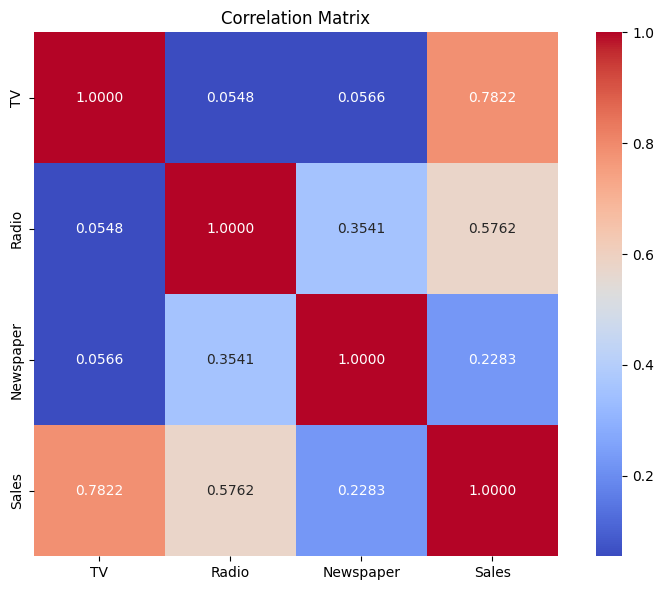

In [11]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Is there a relationship between the response and predictors?

Hypothesis test set H0: beta1 = beta2 = ... = betan = 0

The hypothesis test is peformed by computing the F-statistic. When there is no relationship(H0 is true) between response and predictors, we would expect the F-statistic to take on a value close to 1. If Ha is true, we expect F to be greater than 1.

In our case, F is 570 ad far larger than 1, it provided compelling evidence against the null hypothesis H0. **The large F-statistic suggests that at least one of the advertising media must be related to sales.**

How large does the F-statistic need to be before we can reject H0 and conclude that there is a relationship? It turns out that the answer depends on the values of n and p. When n is large, an Fstatistic that is just a little larger than 1 might still provide evidence again H0. In constrast, a larger F-statistic is needed to reject H0 if n is small. (Incompleted page94)

In [12]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           1.58e-96
Time:                        09:08:14   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

# Deciding on Important Variables

- it is possible that all of the predictor are associated with the response, but it is more often the case that the response is only associated with a subset of the predictors.
- The task of determining which predictors are associated with the response, in order to fit a single model involving only those predictors, is referred to as **variable selection**.
  - Why test all combination of models doesn't work(page96)
  - Three classical approaches for this task:
    - Forward selection
    - backward selection
    - mixed selection

# Model Fit

- RSE and R2 are most important
- The previous table shows R2 of 0.8972 on the model that uses all three advertising media to predict sales.
- if you drop newspaper and calculate the model again, you will have R2 of 0.89719.
- it says even thought p-value(0.860) from preivous table indicates that newspaper is not significant and very weakly associated with the response, R2 will slightly increase when it is added into the model.
- In fact, adding newspaper  to the model leads to tiny increase in R2 provideds additional evidence that newspaper can be dropped from the model.
- If model only contain TV, we will have R2 of 0.61. Adding radio to the model leads to a substantial improvement in R2. This implies that a model that uses TV and radio expenditures to predict sales is substantially better than one that uses only TV advertising.
- We can further quantify this improvement by looking at p-value and R2 in a model that contains only TV and radio.
- Calculate RSE(Page97)

# Prediction

Confidence Interval(page99)

# Synergy/Interaction Effect

- The Linear model states that the average inscrease in sales associated with one-unit inscrease in TV is always Beta1, regardless of the amount spent on radio. However, this simple model may be incorrect.Given a fixed budget of $100,000, spending half on radio and half on TV may increase sales more than allocating the entire amount to either TV or to radio. So, we need to test the Synergy/Interaction effect.
- Formula(P104)